In [1]:
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression

# **Functions**

In [2]:
# filters
import numpy as np
from scipy.signal import butter, filtfilt, sosfiltfilt

def butter_lowpass_filter(data, lowcut, fs, order):
    nyq = fs/2
    low = lowcut/nyq
    b, a = butter(order, low, btype='low')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
    return y

def butter_highpass_filter(data, highcut, fs, order):
    nyq = fs/2
    high = highcut/nyq
    b, a = butter(order, high, btype='high')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
    return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = fs/2
    low = lowcut/nyq
    high = highcut/nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = sosfiltfilt(sos, data) # zero-phase filter # data: [ch x time]
    # specify pandlen to make the result the same as Matlab filtfilt()
    return y

In [5]:
#Pre processing

import numpy as np

def extractEpoch3D(data, event, srate, baseline, frame, opt_keep_baseline):
    # extract epoch from 2D data into 3D [ch x time x trial]
    # input: event, baseline, frame
    # extract epoch = baseline[0] to frame[2]   so the time frame is -200 to 600 ms.

    # for memory pre-allocation
    if opt_keep_baseline == True:
        begin_tmp = int(np.floor(baseline[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-baseline[0])/1000*srate)
    else:
        begin_tmp = int(np.floor(frame[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-frame[0])/1000*srate)

    epoch3D = np.zeros((data.shape[0], end_tmp-begin_tmp, len(event)))
    nth_event = 0 # trial

    for i in event:
        if opt_keep_baseline == True:
            begin_id = int(i + np.floor(baseline[0]/1000 * srate))                 # int(i + begin_tmp)
            end_id = int(begin_id + np.floor((frame[1]-baseline[0])/1000*srate))   # int(i + end_tmp)
        else:
            begin_id = int(i + np.floor(frame[0]/1000 * srate))
            end_id = int(begin_id + np.floor((frame[1]-frame[0])/1000*srate))

        tmp_data = data[:, begin_id:end_id] # extract the time period

        begin_base = int(np.floor(baseline[0]/1000 * srate))
        end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)
        base = np.mean(tmp_data[:, begin_base:end_base], axis=1)

        rmbase_data = tmp_data - base[:, np.newaxis]
        epoch3D[:, :, nth_event] = rmbase_data
        nth_event = nth_event + 1

    return epoch3D

def decimation_by_avg(data, factor):
    """Function for replacing each sequence of previous factor samples with their average"""
    # for example, frame [0, 800]ms -> 17samples (Krusienski et al., 2006)
    # data.shape = [ch, time, trial]
    ratio_dsample = factor
    n_ch, n_frame, n_trial = data.shape

    #print(n_frame)
    decimated_frame = int(np.floor(n_frame/ratio_dsample))
    #print(decimated_frame)

    # memory pre-allocation
    decimated_data = np.zeros((n_ch, decimated_frame, n_trial))
    #print(decimated_data.shape)

    for i in range(n_trial):
        for j in range(decimated_frame):
            cur_data = data[:, :, i]
            decimated_data[:, j, i] = np.mean(cur_data[:, j*ratio_dsample:(j+1)*ratio_dsample], axis=1)

    return decimated_data

def detect_letter_P3speller(pred_score, word_len, label, letter_ind, markers_seq, params):
    """Function for detecing letter from the predicted results from unknown EEG"""
    user_answer = np.chararray(word_len,1)
    acc_on_repetition = np.zeros(params["full_repeat"])
    correct_on_repetition = np.zeros(params["full_repeat"])
    for n_repeat in range(params["full_repeat"]):
        for n_letter in range(word_len):
            # begin and end trial for a single letter session
            begin_trial = len(params["seq_code"]) * params["full_repeat"] * (n_letter)
            end_trial = begin_trial + (n_repeat+1) * len(params["seq_code"])

            unknown_speller_code = np.zeros(len(params["seq_code"]))
            for j in range(begin_trial, end_trial):
                # predict and add lda score
                unknown_speller_code[int(markers_seq[letter_ind[j]])-1] = unknown_speller_code[int(markers_seq[letter_ind[j]])-1] + pred_score[j]

            row = np.argmax(unknown_speller_code[0:6])
            col = np.argmax(unknown_speller_code[6:12])
            user_answer[n_letter] = params['spellermatrix'][row*6+col]
        user_answer_string = user_answer.tobytes().decode()

        correct_on_repetition[n_repeat] = len([i for i, j in zip(user_answer_string, label) if i == j])
        acc_on_repetition[n_repeat] = correct_on_repetition[n_repeat] / len(label)

    out = {"text_result": user_answer_string, "acc_on_repetition": acc_on_repetition, "correct_on_repetition": correct_on_repetition}
    return out

In [8]:
#Classifier

import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression

def get_stats(dat, x_columns, y):
    x = dat[:, x_columns]
    results = sm.OLS(y, x).fit()
    return results

def stepwise_linear_model(dat, init_x_column, y_train, p_val):
    x_column = init_x_column

    while True:
        results_stats = get_stats(dat, x_column, y_train)
        if np.max(results_stats.pvalues) <= p_val:
            break
        else:
            backward_elim = np.argmax(results_stats.pvalues)
            x_column = np.delete(x_column, backward_elim)

    return x_column, results_stats


In [10]:
from google.colab import drive

In [24]:
!pip install mat73

In [18]:
import mat73
import scipy
import scipy.io as sio # cannot use for v7.3 mat file
import numpy as np
import matplotlib.pyplot as plt

In [13]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
# pre-defined parameters
baseline = [-200, 0] # in ms
frame = [0, 600] # in ms

In [29]:
EEG = sio.loadmat("/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/s55.mat")

NotImplementedError: Please use HDF reader for matlab v7.3 files, e.g. h5py

In [31]:
EEG = mat73.loadmat("/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/s01.mat")

# **Visualizaion**

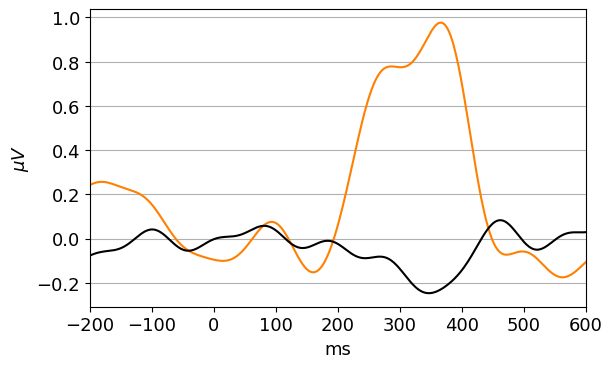

In [58]:
for n_calib in range(len(EEG['test'])):
  cur_EEG = EEG['test'][n_calib]
  data = np.asarray(cur_EEG['data'])
  srate = cur_EEG['srate']
  data = butter_bandpass_filter(data, 1, 10, srate, 4)
  markers = cur_EEG['markers_target']

  targetID = np.where(markers==1)[0]
  nontargetID = np.where(markers==2)[0]

  tmp_targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, True)
  tmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, True)
  if n_calib == 0:
    targetEEG = tmp_targetEEG
    nontargetEEG = tmp_nontargetEEG
  else:
    targetEEG = np.dstack((targetEEG, tmp_targetEEG))
    nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))

avg_target = np.mean(targetEEG, axis=2) # trial average
avg_nontarget = np.mean(nontargetEEG, axis=2) # trial average

# Channel selection for drawing ERPs
elec_midline = [31-1, 32-1, 13-1] # Fz, Cz, and Pz, respectively, -1 for indexing
ch_avg_target = np.mean(avg_target[elec_midline, :], axis=0)
ch_avg_nontarget = np.mean(avg_nontarget[elec_midline, :], axis=0)

# Single subject averaged target & nontarget ERPs - visualization
t = np.linspace(-200, 600, avg_target.shape[1])
plt.plot(t, ch_avg_target.transpose(), color=[1, 0.5, 0])
plt.plot(t, ch_avg_nontarget.transpose(), color=[0, 0, 0])
plt.xlabel('ms')
plt.ylabel(r'$\mu V$')
plt.gca().yaxis.grid(True)
plt.rcParams.update({'font.size': 13})
plt.xlim([-200, 600])

# plot ratio
ratio = .6
x_left, x_right = plt.gca().get_xlim()
y_low, y_high = plt.gca().get_ylim()

plt.gca().set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.show()

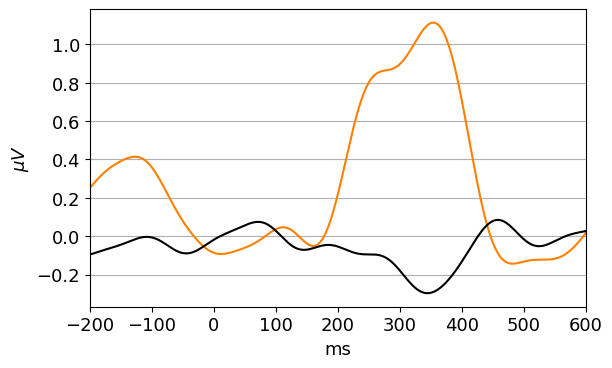

In [59]:
for n_calib in range(len(EEG['train'])):
  cur_EEG = EEG['test'][n_calib]
  data = np.asarray(cur_EEG['data'])
  srate = cur_EEG['srate']
  data = butter_bandpass_filter(data, 1, 10, srate, 4)
  markers = cur_EEG['markers_target']

  targetID = np.where(markers==1)[0]
  nontargetID = np.where(markers==2)[0]

  tmp_targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, True)
  tmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, True)
  if n_calib == 0:
    targetEEG = tmp_targetEEG
    nontargetEEG = tmp_nontargetEEG
  else:
    targetEEG = np.dstack((targetEEG, tmp_targetEEG))
    nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))

avg_target = np.mean(targetEEG, axis=2) # trial average
avg_nontarget = np.mean(nontargetEEG, axis=2) # trial average

# Channel selection for drawing ERPs
elec_midline = [31-1, 32-1, 13-1] # Fz, Cz, and Pz, respectively, -1 for indexing
ch_avg_target = np.mean(avg_target[elec_midline, :], axis=0)
ch_avg_nontarget = np.mean(avg_nontarget[elec_midline, :], axis=0)

# Single subject averaged target & nontarget ERPs - visualization
t = np.linspace(-200, 600, avg_target.shape[1])
plt.plot(t, ch_avg_target.transpose(), color=[1, 0.5, 0])
plt.plot(t, ch_avg_nontarget.transpose(), color=[0, 0, 0])
plt.xlabel('ms')
plt.ylabel(r'$\mu V$')
plt.gca().yaxis.grid(True)
plt.rcParams.update({'font.size': 13})
plt.xlim([-200, 600])

# plot ratio
ratio = .6
x_left, x_right = plt.gca().get_xlim()
y_low, y_high = plt.gca().get_ylim()

plt.gca().set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.show()

# **Code for prediction letters**

In [40]:
#Load Dataset

nsub = 1
path = '/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/'
EEg= mat73.loadmat(path+'s{:02d}.mat'.format(int(nsub))) # 's{:02d}.mat': This is a string specifying the name of the MATLAB file to be loaded. It includes a placeholder ({:02d}) for an integer (nsub), where the integer is formatted with at least two digits (padded with zeros if needed). This suggests that the MATLAB files are named in a structured way, with 's' followed by a two-digit number and ending with '.mat'.


# for i in range(1,55):
#   EEg= mat73.loadmat(path+'s{:02d}.mat'.format(int(nsub)))





In [45]:
#Pre-processing for training EEG

for n_calib in range(len(EEG['train'])):
    cur_eeg = EEG['train'][n_calib]
    data = np.asarray(cur_eeg['data'])
    srate = cur_eeg['srate']
    data = butter_bandpass_filter(data, 0.5, 10, srate, 4)
    markers = cur_eeg['markers_target']

    targetID = np.where(markers==1)[0]
    nontargetID = np.where(markers==2)[0]

    tmp_targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, False)
    tmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, False)
    if n_calib == 0:
        targetEEG = tmp_targetEEG
        nontargetEEG = tmp_nontargetEEG
    else:
        targetEEG = np.dstack((targetEEG, tmp_targetEEG)) # np.dstack is a function that stacks arrays in sequence along the third axis (depth). Given a sequence of arrays with the same shape along the first two dimensions, np.dstack concatenates them along the third axis. The function name "dstack" stands for "depth stack."
        nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))


In [56]:
print((targetEEG).shape)

print(targetEEG[0][0])



(32, 307, 300)
[-3.69354240e+00  1.35540879e+00  6.42631313e+00 -7.45815905e+00
  2.39313006e+00 -2.56577155e+00  7.00504856e-01  8.04677571e+00
  2.31459579e+00 -5.67259024e-01 -5.67411075e+00 -4.92733924e+00
 -3.13850603e+00  2.18231791e+00 -4.85946645e+00 -9.21602309e-01
  1.29156280e+00  9.82222132e-01  3.22312883e+00  1.81776928e+00
  7.65483422e+00  3.34472366e+00 -5.64604657e+00 -5.38539778e+00
  5.76336461e-01  7.28319647e+00  3.30162008e+00  1.40782959e-01
  1.73032745e+00 -3.87399622e+00 -2.91569452e+00  1.27129126e+01
 -4.41916679e+01  8.66573696e+00 -2.17417060e+00 -1.18507583e+00
  1.28116751e+00  9.17584017e+00  5.76330688e+00 -8.54490717e-01
 -8.12386106e-01  2.21089537e+00  1.97667077e+00 -4.65445562e+00
 -5.92103958e+00 -2.91794468e+00  5.51565891e+00  8.10343144e-02
 -1.45571100e+00  3.70029443e+00 -1.09247042e+00 -1.46435943e+00
 -1.83989018e+00 -2.93066749e+00  3.77725827e+00  3.00941916e+00
  7.22074731e+00 -3.07926934e+00 -1.11358430e+00  1.70756316e+00
  3.330690

In [66]:
cur_eeg = EEG['train'][0]
data = np.asarray(cur_eeg['data'])
srate = cur_eeg['srate']
data = butter_bandpass_filter(data, 0.5, 10, srate, 4)
markers = cur_eeg['markers_target']

targetID = np.where(markers==1)[0]
nontargetID = np.where(markers==2)[0]

#tmp_targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, False)

########
opt_keep_baseline = False
event = targetID
if opt_keep_baseline == True:
        begin_tmp = int(np.floor(baseline[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-baseline[0])/1000*srate)
else:
    begin_tmp = int(np.floor(frame[0]/1000*srate))
    end_tmp = int(begin_tmp+np.floor(frame[1]-frame[0])/1000*srate)

epoch3D = np.zeros((data.shape[0], end_tmp-begin_tmp, len(event)))
nth_event = 0

for i in event:
  print(i)
  if opt_keep_baseline == True:
      begin_id = int(i + np.floor(baseline[0]/1000 * srate))                 # int(i + begin_tmp)
      end_id = int(begin_id + np.floor((frame[1]-baseline[0])/1000*srate))   # int(i + end_tmp)
  else:
      begin_id = int(i + np.floor(frame[0]/1000 * srate))
      end_id = int(begin_id + np.floor((frame[1]-frame[0])/1000*srate))

  tmp_data = data[:, begin_id:end_id] # extract the time period

  print(tmp_data[31][-4:-1])
  print("************")

  print(tmp_data.shape)

  begin_base = int(np.floor(baseline[0]/1000 * srate))
  end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)

  print(begin_base, end_base)

  print(tmp_data[:, begin_base:end_base])

  print("************")

  base = np.mean(tmp_data[:, begin_base:end_base], axis=1)

  print(base)

  print(base.shape)


  rmbase_data = tmp_data - base[:, np.newaxis]

  print(rmbase_data.shape)
  epoch3D[:, :, nth_event] = rmbase_data
  nth_event = nth_event + 1

  break


















#######
'''

tmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, False)



if n_calib == 0:
    targetEEG = tmp_targetEEG
    nontargetEEG = tmp_nontargetEEG
else:
    targetEEG = np.dstack((targetEEG, tmp_targetEEG)) # np.dstack is a function that stacks arrays in sequence along the third axis (depth). Given a sequence of arrays with the same shape along the first two dimensions, np.dstack concatenates them along the third axis. The function name "dstack" stands for "depth stack."
    nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))

'''

5312
[-2.5527287  -2.61840042 -2.67810898]
************
(32, 307)
-103 -2
[[-0.60247944 -0.40531306 -0.18772458 ...  8.54906275  8.37223961
   8.17861619]
 [ 0.16580546  0.36820443  0.58364621 ...  3.30048047  3.01432067
   2.72389688]
 [-2.95689124 -2.97721832 -2.98695227 ...  6.34266068  6.19407067
   6.05118269]
 ...
 [ 1.65667874  1.85713139  2.06487172 ...  5.39395854  5.39711785
   5.3862229 ]
 [ 4.66336085  4.9638802   5.26831875 ... -1.10181366 -1.67536971
  -2.24872597]
 [ 2.97888029  3.06560243  3.15133863 ... -2.4817619  -2.5527287
  -2.61840042]]
************
[ 3.75421241  3.55889138  2.99931111  4.92761112  3.11619343  2.64868893
  2.80743435  2.57430573 -0.75922828 -0.75500272 -1.76032697 -1.95206078
 -1.40804581 -2.66901128 -1.74121279 -3.43788894 -2.96715614 -3.53546575
 -0.26575264 -3.81102743 -2.82585142 -0.91306291 -1.31920897 -1.68327524
 -3.54570848  1.9544208   0.87948873 -3.08138656  0.88126568  2.01343518
  4.70714277  1.60827147]
(32,)
(32, 307)


'\n\ntmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, False)\n\n\n\nif n_calib == 0:\n    targetEEG = tmp_targetEEG\n    nontargetEEG = tmp_nontargetEEG\nelse:\n    targetEEG = np.dstack((targetEEG, tmp_targetEEG)) # np.dstack is a function that stacks arrays in sequence along the third axis (depth). Given a sequence of arrays with the same shape along the first two dimensions, np.dstack concatenates them along the third axis. The function name "dstack" stands for "depth stack."\n    nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))\n\n'

In [ ]:










if opt_keep_baseline == True:
        begin_tmp = int(np.floor(baseline[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-baseline[0])/1000*srate)
    else:
        begin_tmp = int(np.floor(frame[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-frame[0])/1000*srate)

epoch3D = np.zeros((data.shape[0], end_tmp-begin_tmp, len(event)))
nth_event = 0

for i in event:
  if opt_keep_baseline == True:
      begin_id = int(i + np.floor(baseline[0]/1000 * srate))                 # int(i + begin_tmp)
      end_id = int(begin_id + np.floor((frame[1]-baseline[0])/1000*srate))   # int(i + end_tmp)
  else:
      begin_id = int(i + np.floor(frame[0]/1000 * srate))
      end_id = int(begin_id + np.floor((frame[1]-frame[0])/1000*srate))

  tmp_data = data[:, begin_id:end_id] # extract the time period

  begin_base = int(np.floor(baseline[0]/1000 * srate))
  end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)
  base = np.mean(tmp_data[:, begin_base:end_base], axis=1)

  rmbase_data = tmp_data - base[:, np.newaxis]
  epoch3D[:, :, nth_event] = rmbase_data
  nth_event = nth_event + 1